# XCAST DEMO
First, we need to install XCast

In [1]:
!conda install -y -c hallkjc01 xcast 

In [1]:
import src as xc 
import xarray as xr
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs 
import numpy as np

## Set Up Test DataSet 
This dataset is good because it is a realistic use case - preparing a forecast for SASCOF. There is also some missing data in there, which allows us to demostrate the treatement of missing data in regridding / blurring. 

In [2]:
# Forecast Files 
cans_fcst = xr.open_dataset('test_data/SASCOF/cansipsv2_fcst.nc', decode_times=False, chunks='auto')
cfsv2_fcst = xr.open_dataset('test_data/SASCOF/cfsv2_fcst.nc', decode_times=False, chunks='auto')
cola_fcst = xr.open_dataset('test_data/SASCOF/cola_fcst.nc', decode_times=False, chunks='auto')
nasa_fcst = xr.open_dataset('test_data/SASCOF/nasa_fcst.nc', decode_times=False, chunks='auto')
F = xr.concat([cans_fcst, cfsv2_fcst, cola_fcst, nasa_fcst], 'M').assign_coords({'M':[0,1,2,3]}).mean('L').prec

# Hindcast Files 
cans_hcst = xr.open_dataset('test_data/SASCOF/cansipsv2_hcst.nc', decode_times=False, chunks='auto')
cfsv2_hcst = xr.open_dataset('test_data/SASCOF/cfsv2_hcst.nc', decode_times=False, chunks='auto')
cola_hcst = xr.open_dataset('test_data/SASCOF/cola_hcst.nc', decode_times=False, chunks='auto')
nasa_hcst = xr.open_dataset('test_data/SASCOF/nasa_hcst.nc', decode_times=False, chunks='auto')
X = xr.concat([cans_hcst, cfsv2_hcst, cola_hcst, nasa_hcst], 'M').assign_coords({'M':[0,1,2,3]}).mean('L').prec

# Observation File 
Y = xr.open_dataset('test_data/SASCOF/observed_rainfall.nc', decode_times=False, chunks='auto').expand_dims({'M':[0]}).rf

## Utilities
XCast provides a number of data-wrangling and preprocessing utilities:
* Regridding - interpolating data onto different resolutions with bivariate spline interpolation
* Gaussian Smoothing - Apply a Guassian Smoothing kernel to the the data across the spatial dimension
* MinMax Scaling - Scale data to [-1, 1] while maintaining its distribution 
* Normal Scaling - Scale data to Mean=0, StdDev=1


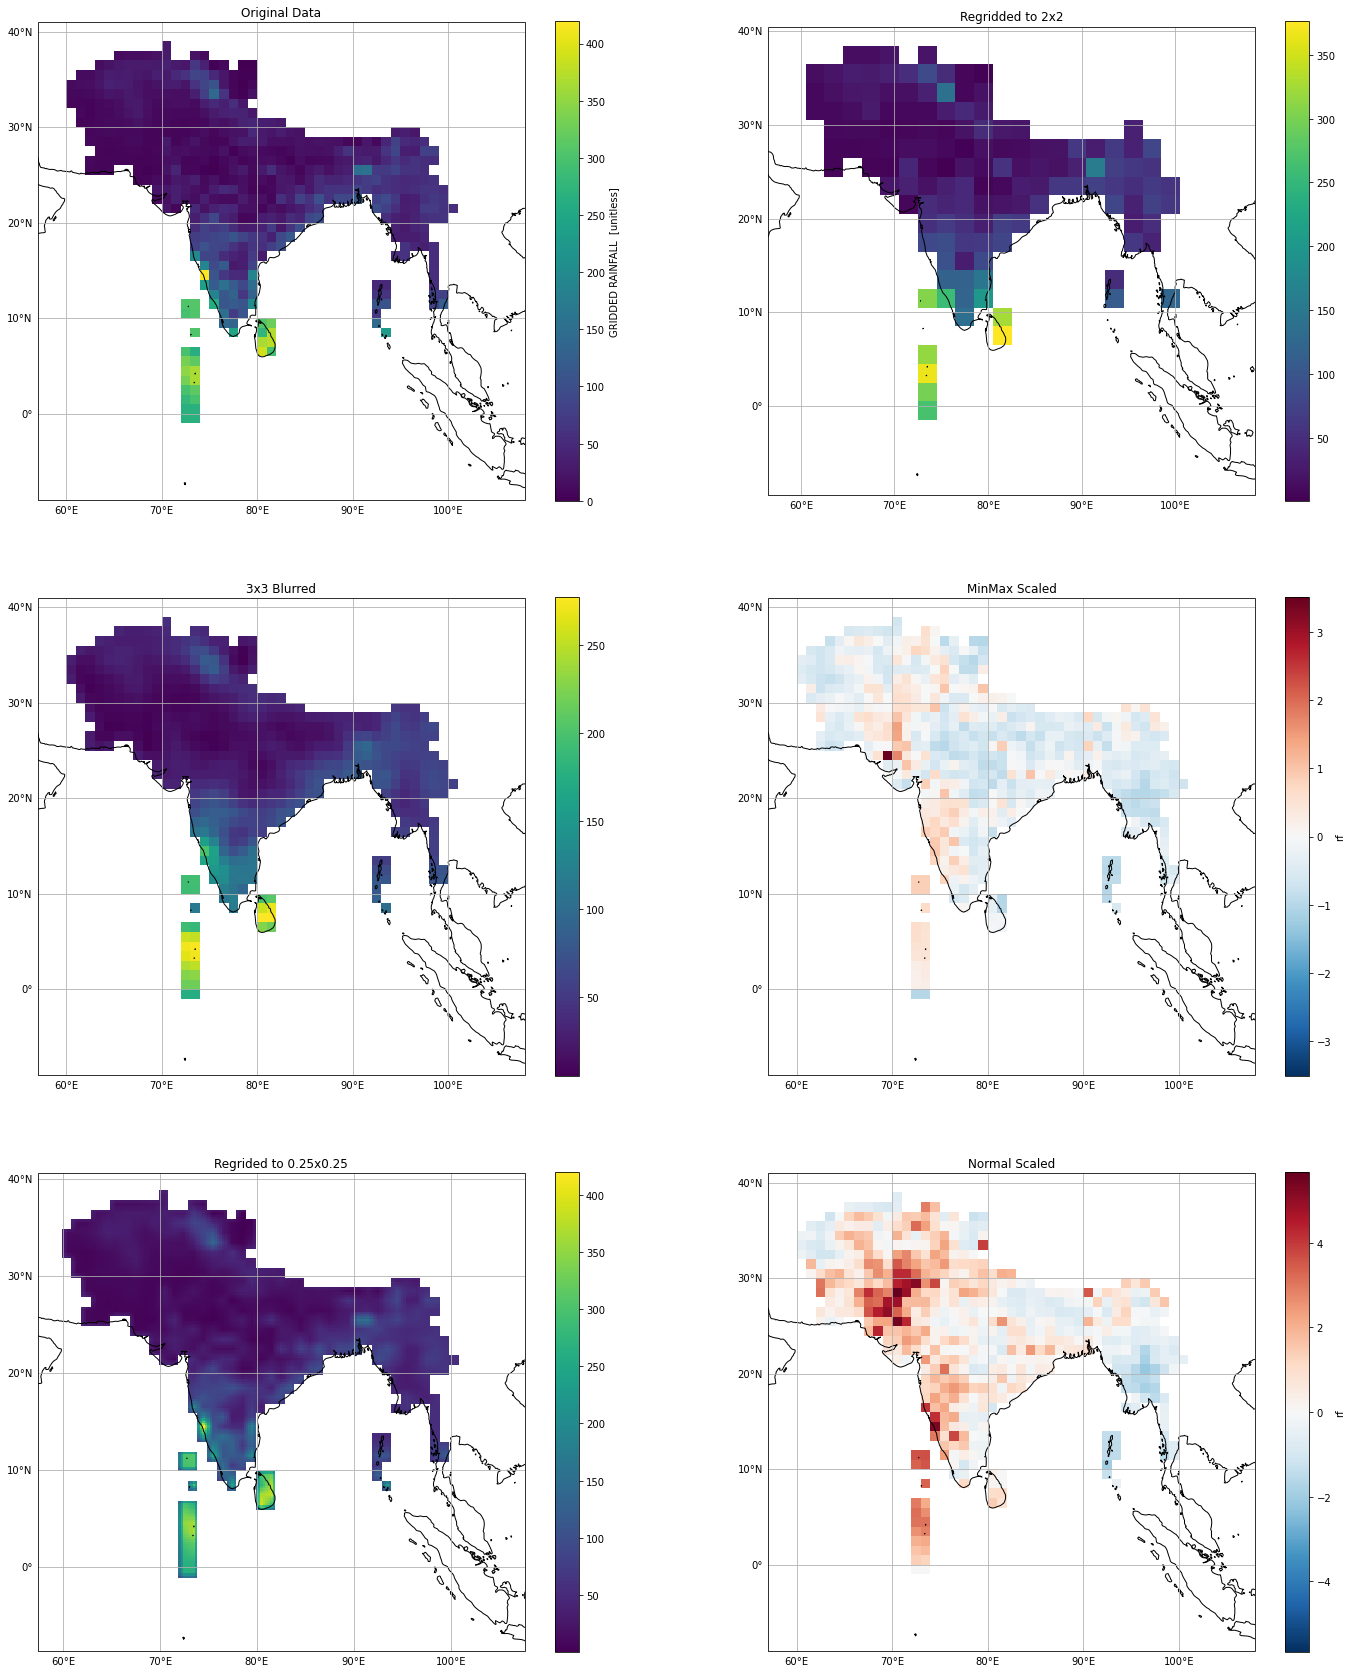

In [5]:
# first, demonstrate regridding to a coarser grid
lats2x2 = Y.coords['LATITUDE'].values[::2]
lons2x2 = Y.coords['LONGITUDE'].values[::2]
regridded2x2 = xc.regrid(Y, lons2x2, lats2x2, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M').isel(time=-1, M=0)


# Now, demonstrate regriddint to a finer grid
lats0p25x0p25 = np.linspace(np.min(Y.coords['LATITUDE'].values), np.max(Y.coords['LATITUDE'].values), int((np.max(Y.coords['LATITUDE'].values)- np.min(Y.coords['LATITUDE'].values) ) // 0.25 + 1) ) 
lons0p25x0p25 = np.linspace(np.min(Y.coords['LONGITUDE'].values), np.max(Y.coords['LONGITUDE'].values), int((np.max(Y.coords['LONGITUDE'].values)- np.min(Y.coords['LONGITUDE'].values) ) // 0.25 + 1) ) 
regridded0p25x0p25 = xc.regrid(Y, lons0p25x0p25, lats0p25x0p25, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M').isel(time=-1, M=0)

# Demonstrate Gaussian Blurring 
blurred = xc.gaussian_smooth(Y, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M', kernel=(3,3)).isel(time=-1, M=0)

# demonstrate MinMax Scaling 
minmax = xc.MinMax()
minmax.fit(Y, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M')
mmscaled = minmax.transform(Y, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M').isel(M=0, time=-1)

# this is the original data, to compare 
original = Y.isel(M=0, time=-1)

# finally, demonstrate normal scaling 
normal = xc.Normal()
normal.fit(Y, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M')
nscaled = normal.transform(Y, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_sample_dim='time', x_feature_dim='M').isel(M=0, time=-1)


plots = [[original, regridded2x2],
         [blurred, mmscaled],
         [regridded0p25x0p25, nscaled]
        ]
fig, axes = plt.subplots(nrows=3, ncols=2,  subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(24, 30))

titles = [['Original Data', 'Regridded to 2x2'], ['3x3 Blurred', 'MinMax Scaled'], ['Regrided to 0.25x0.25', 'Normal Scaled']]
for i in range(len(plots)):
    for j in range(len(plots[0])):
        plots[i][j].plot(ax=axes[i][j])
        axes[i][j].coastlines()
        axes[i][j].set_title(titles[i][j])
        gl = axes[i][j].gridlines()
        gl.xlabels_bottom, gl.ylabels_left = True, True

# Dimensionality Reduction
Xcast allows you to reduce the dimensionality of your dataset across the spatial dimensions, or across the feature dimension. 
* Feature Decomposition - Transform your feature dimension into orthogonal modes using PCA, NMF, Dictionary Learning, etc
* Spatial PCA - Identify orthogonal spatial patterns in the data

### Feature PCA

In [6]:
PCA = xc.PrincipalComponentsAnalysis(n_components=3)
PCA.fit(X, x_lat_dim='Y', x_lon_dim='X', x_feature_dim='M', x_sample_dim='S')
transformed = PCA.transform(X, x_lat_dim='Y', x_lon_dim='X', x_feature_dim='M', x_sample_dim='S')

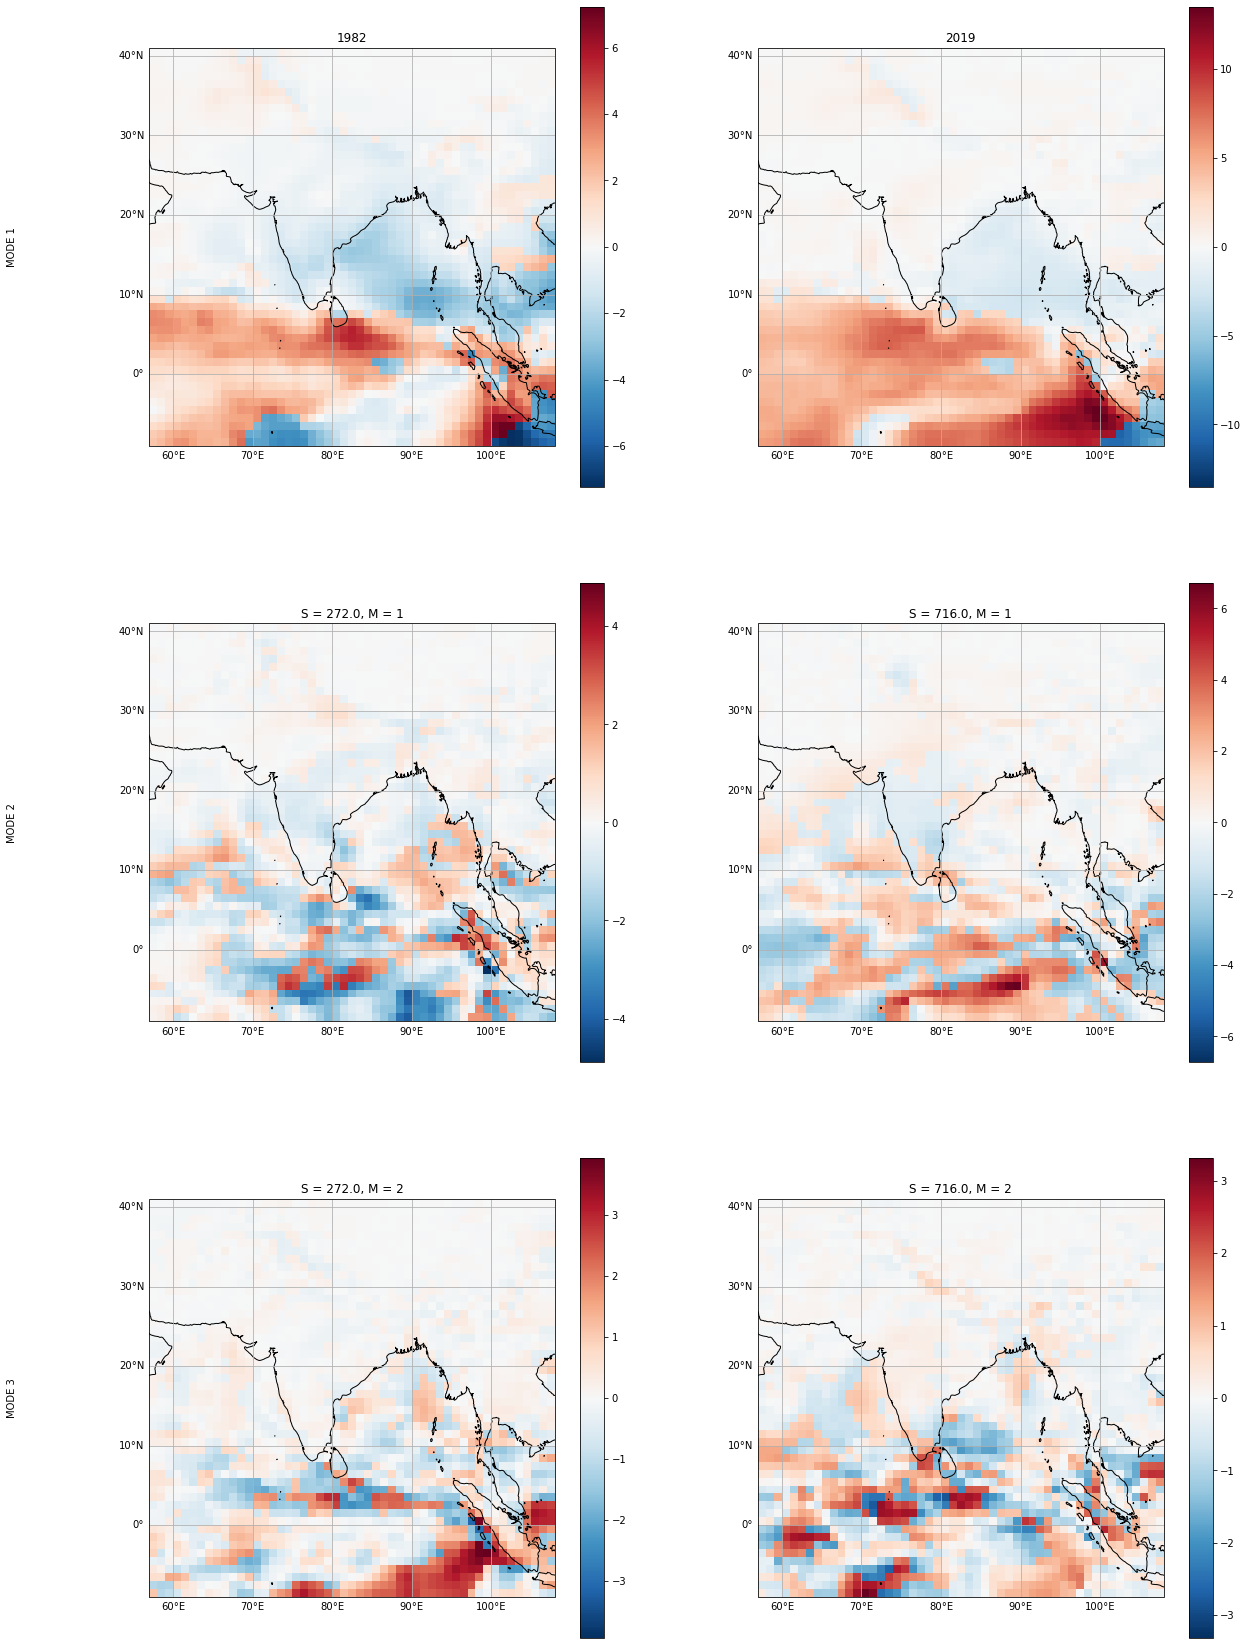

In [7]:
plots = [[transformed.isel(M=0, S=0), transformed.isel(M=0, S=-1)],
         [transformed.isel(M=1, S=0), transformed.isel(M=1, S=-1)],
         [transformed.isel(M=2, S=0), transformed.isel(M=2, S=-1)],
        ]
fig, axes = plt.subplots(nrows=3, ncols=2,  subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(20, 30))

titles = ['1982', '2019']
variables = ['MODE 1', 'MODE 2', 'MODE 3']
for i in range(len(plots)):
    axes[i][0].text(-0.35,0.5,variables[i],rotation=90,verticalalignment='center', transform=axes[i][0].transAxes)
    for j in range(len(plots[0])):
        plots[i][j].plot(ax=axes[i][j])
        axes[i][j].coastlines()
        axes[0][j].set_title(titles[j])
        gl = axes[i][j].gridlines()
        gl.xlabels_bottom, gl.ylabels_left = True, True

### Spatial PCA

In [8]:
SPCA = xc.SpatialPCA()
SPCA.fit(Y, x_lat_dim='LATITUDE', x_lon_dim='LONGITUDE', x_feature_dim='M', x_sample_dim='time')
eofs = SPCA.eofs()

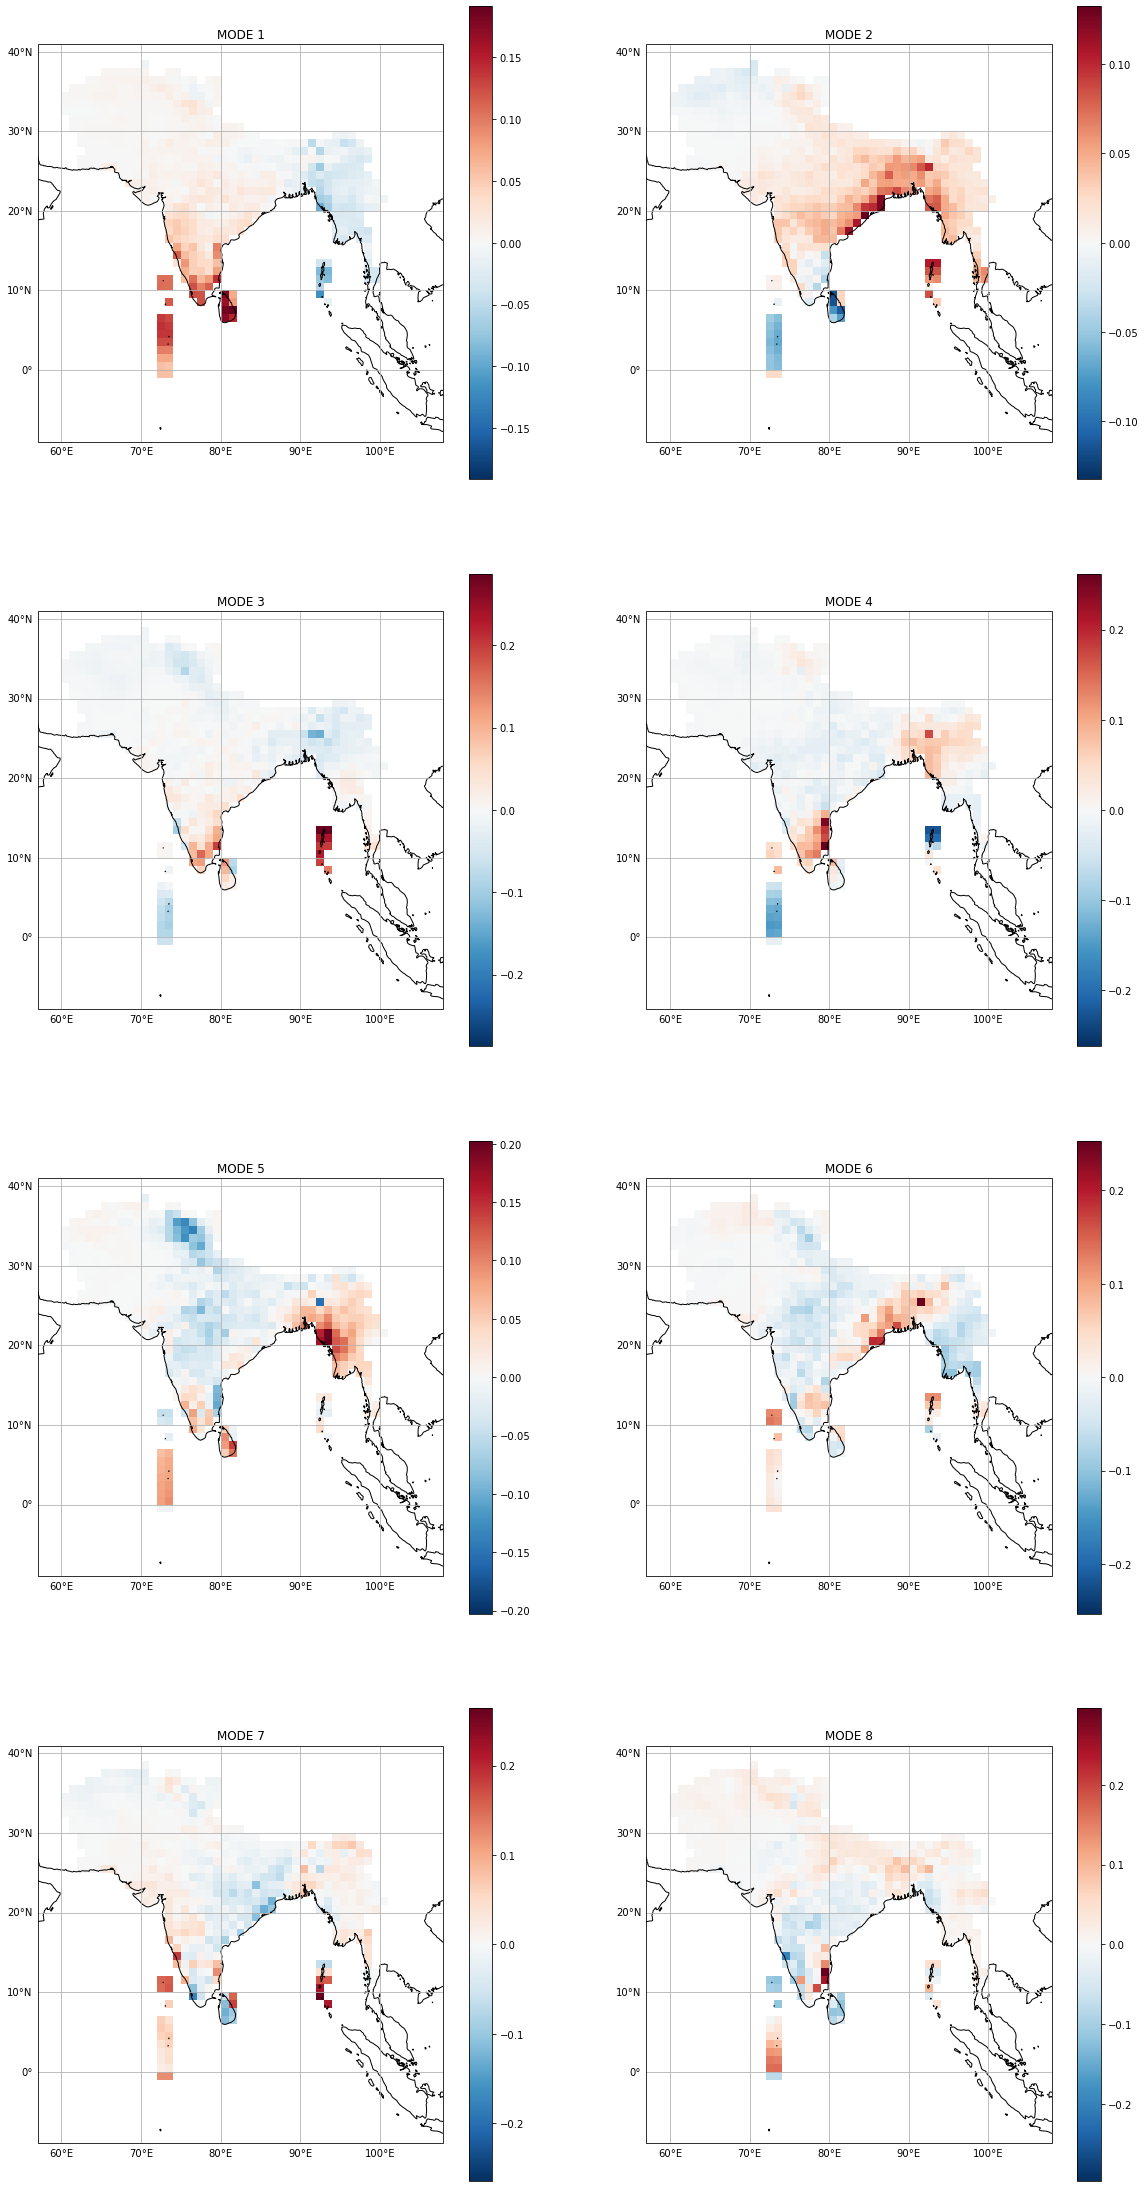

In [9]:
plots = [[eofs.isel(M=0, MODE=0), eofs.isel(M=0, MODE=1)],
         [eofs.isel(M=0, MODE=2), eofs.isel(M=0, MODE=3)],
         [eofs.isel(M=0, MODE=4), eofs.isel(M=0, MODE=5)],
         [eofs.isel(M=0, MODE=6), eofs.isel(M=0, MODE=7)]
        ]
fig, axes = plt.subplots(nrows=4, ncols=2,  subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(20, 40))

titles = [['MODE 1', 'MODE 2'],['MODE 3', 'MODE 4'],['MODE 5', 'MODE 6'],['MODE 7', 'MODE 8']]
for i in range(len(plots)):
    #axes[i][0].text(-0.35,0.5,variables[i],rotation=90,verticalalignment='center', transform=axes[i][0].transAxes)
    for j in range(len(plots[0])):
        plots[i][j].plot(ax=axes[i][j])
        axes[i][j].coastlines()
        axes[i][j].set_title(titles[i][j])
        gl = axes[i][j].gridlines()
        gl.xlabels_bottom, gl.ylabels_left = True, True

# Regression
Xcast allows us to easily scale any Python regression method to gridded spatial data gridpoint-by-gridpoint. 
* **MultipleLinearRegression** (sklearn.linear_model.LinearRegression) 
* **PoissonRegression** (sklearn.linear_model.PoissonRegressor)
* **GammaRegression** (sklearn.linear_model.GammaRegressor)
* **MultiLayerPerceptron** (sklearn.neural_network.MLPRegressor) (**Slow**)
* **RandomForest** (sklearn.ensemble.RandomForestRegressor)  (**Slow**) 
* **RidgeRegressor** (sklearn.linear_model.Ridge) 
* **ExtremeLearningMachine** (xcast.regression.ELMRegressors) 

#### MLR 
Since MLR is a deterministic regression method, we only have to run it once, the results don't change

Fitting LinearRegression: [*************************] (2550/2550) 0:00:06.880651
Predicting LinearRegression: [*************************] (2550/2550) 0:00:08.573063
15.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


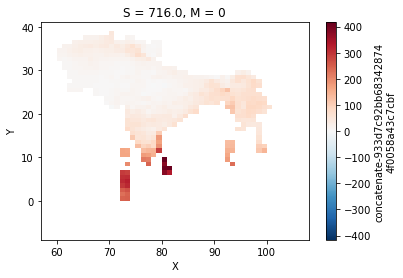

In [10]:
%%timeit -n 1 -r 1
mlr = xc.MultipleRegressionMME(ND=1)
mlr.fit(X, Y, x_sample_dim='S', y_sample_dim='time', y_lat_dim='LATITUDE', y_lon_dim='LONGITUDE', lat_chunks=10, lon_chunks=10, parallel_in_memory=False, verbose=True)
mlr_predictions = mlr.predict(X, x_sample_dim='S', lat_chunks=10, lon_chunks=10,  verbose=True)
mlr_predictions.mean('ND').isel(M=0, S=-1).plot()

### ELM 
ELM, though, is a non-deterministic regression method- so we should run it multiple times, to get a better idea of the distribution of its results.

In [ ]:
%%timeit -n 1 -r 1
elm = xc.ExtremeLearningMachine(ND=10)
elm.fit(X, Y, x_sample_dim='S', y_sample_dim='time', y_lat_dim='LATITUDE', y_lon_dim='LONGITUDE', lat_chunks=10, lon_chunks=10, parallel_in_memory=False, verbose=True)
elm_predictions = elm.predict(X, x_sample_dim='S', lat_chunks=10, lon_chunks=10,  verbose=True)
elm_predictions.mean('ND').isel(M=0, S=-1).plot()


### Implementing New Pointwise Regressor Classes
It is easy to extend xcast- look at all you have to do to implement XGBoostRegression: 

Fitting XGBRegressor: [*************************] (2550/2550) 0:01:44.169898
Predicting XGBRegressor: [*************************] (2550/2550) 0:00:07.162332


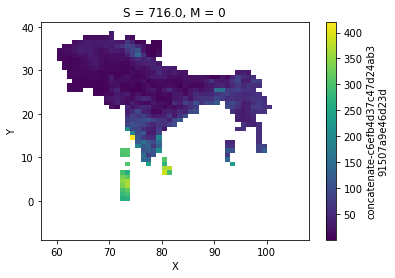

In [11]:
#!conda install -y -c conda-forge xgboost  # uncomment this line if you need to install xgboost
import xgboost 
class XGBoostRegressor(xc.BaseRegressor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.model_type = xgboost.XGBRegressor#(**kwargs)

xgb = XGBoostRegressor(ND=1)
xgb.fit(X, Y, x_sample_dim='S', y_sample_dim='time', y_lat_dim='LATITUDE', y_lon_dim='LONGITUDE', lat_chunks=10, lon_chunks=10, parallel_in_memory=False, verbose=True)
xgb_predictions = xgb.predict(X, x_sample_dim='S', lat_chunks=10, lon_chunks=10,  verbose=True)
xgb_predictions.mean('ND').isel(M=0, S=-1).plot()
        

# Cross Validation
XCast also implements Leave-N-Out cross-validation in the same style as SciKit-Learn's 'KFold'

In [13]:
import src.mme as mme
bcem_hcst = xc.cross_validate(mme.BiasCorrectedEnsembleMeanMME, X, Y, x_sample_dim='S', y_sample_dim='time', y_lat_dim='LATITUDE', y_lon_dim='LONGITUDE', verbose=True, window=5, ND=10)
elm_hcst = xc.cross_validate(xc.ExtremeLearningMachineRegression, X, Y, x_sample_dim='S', y_sample_dim='time', y_lat_dim='LATITUDE', y_lon_dim='LONGITUDE', verbose=True, window=5, ND=10, lat_chunks=10, lon_chunks=10, hidden_layer_size=5, parallel_in_memory=True)

 CROSSVALIDATING BiasCorrectedEnsembleMeanMME:  [*************************] (8/8) 0:00:00.816441
 CROSSVALIDATING ExtremeLearningMachineRegression:  [*************************] (8/8) 0:00:47.244385


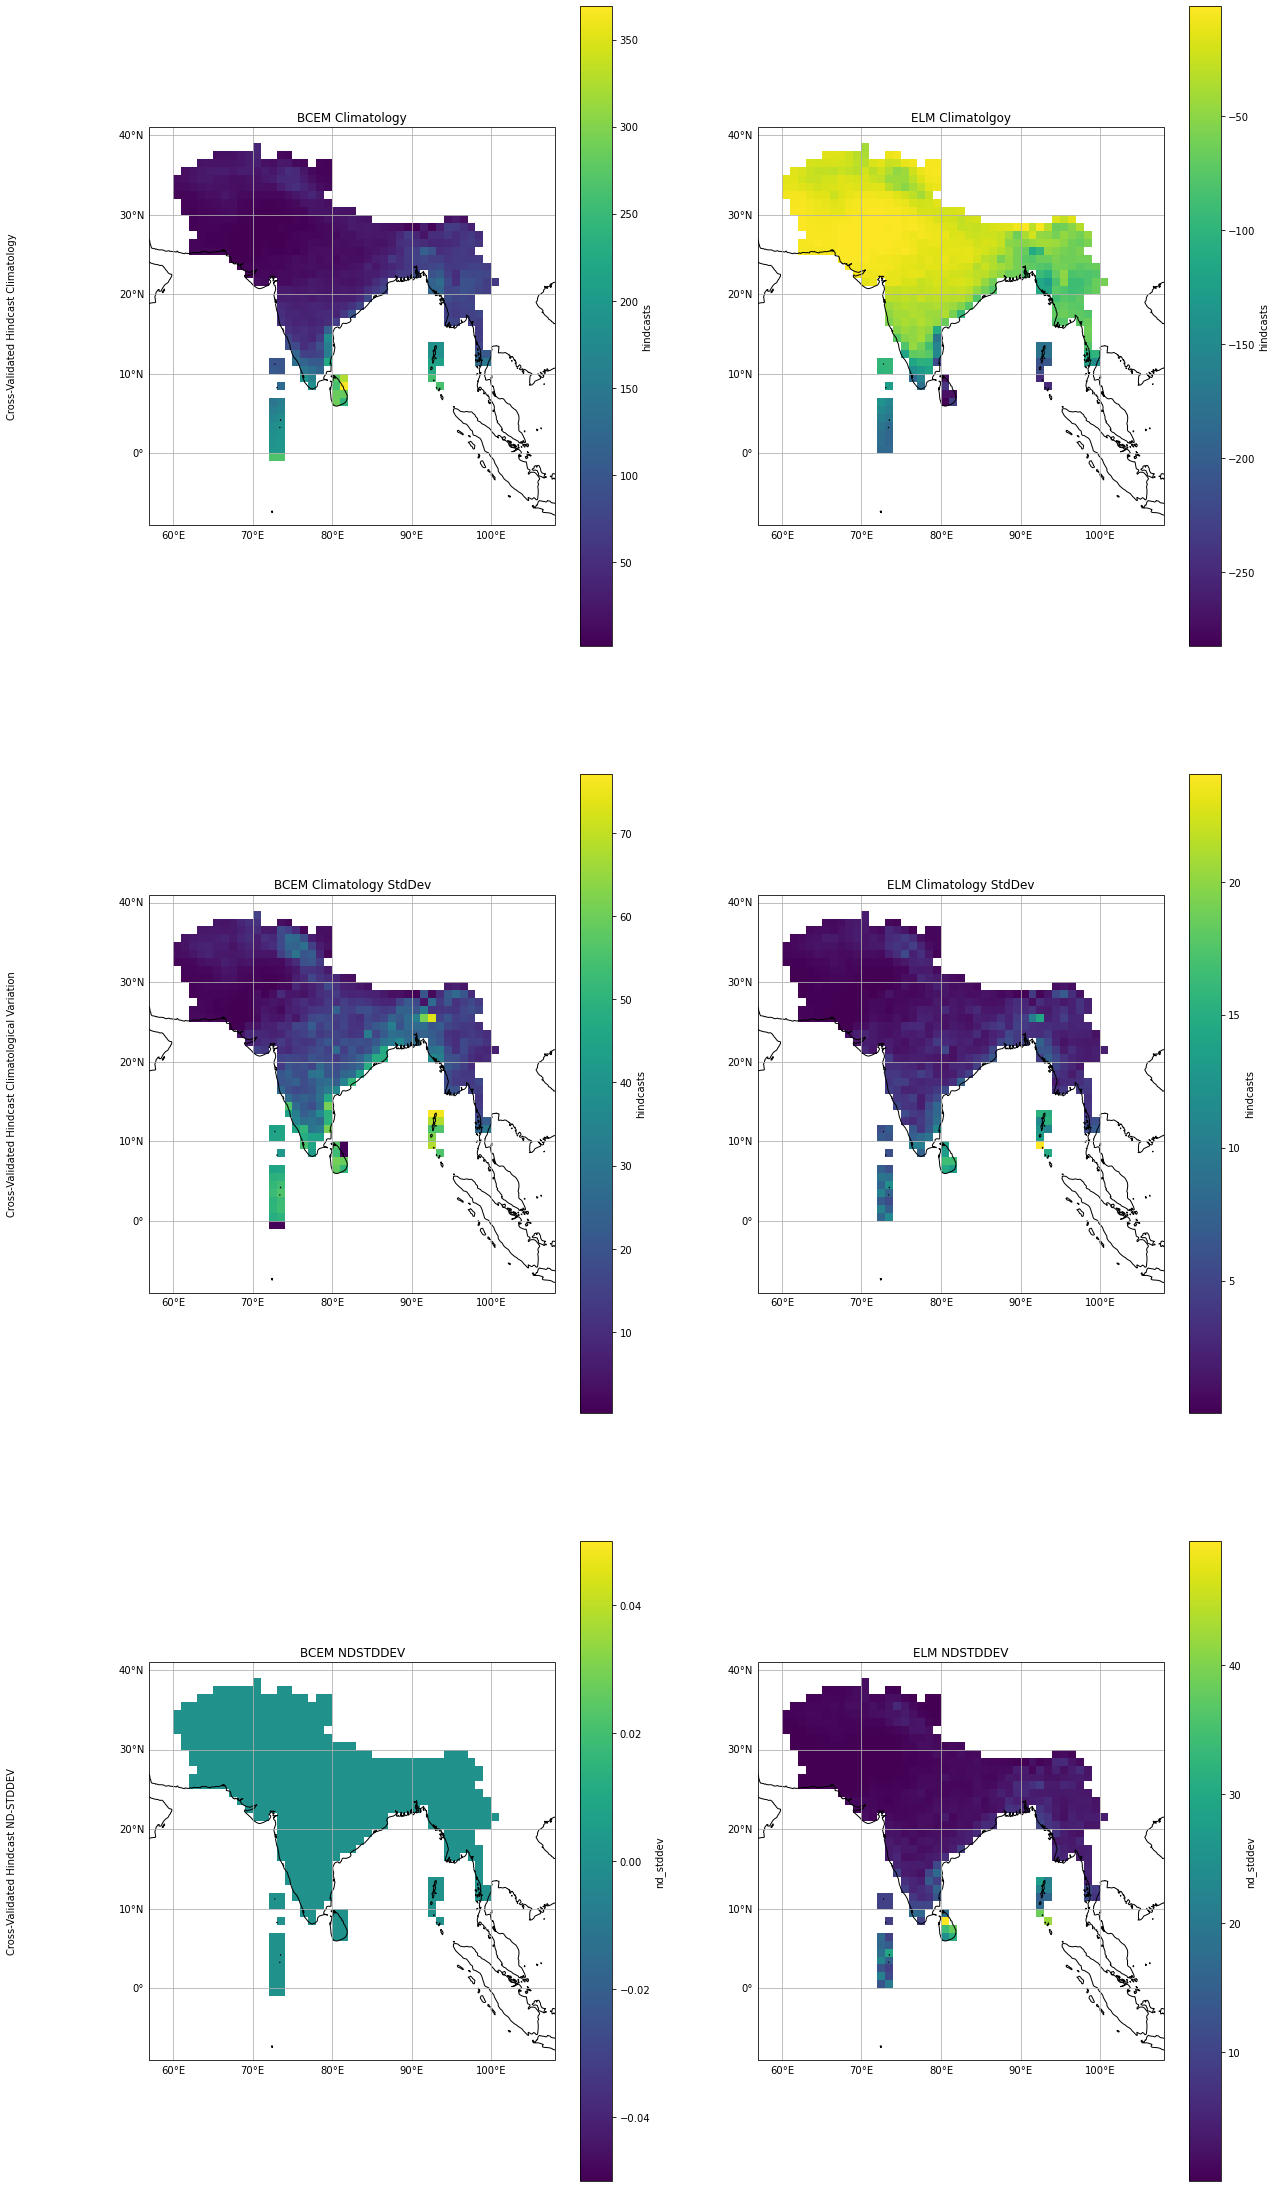

In [14]:
plots = [[bcem_hcst.hindcasts.isel(M=0).mean('S'), elm_hcst.hindcasts.isel(M=0).mean('S')],
         [bcem_hcst.hindcasts.isel(M=0).std('S'), elm_hcst.hindcasts.isel(M=0).std('S')],
        [bcem_hcst.nd_stddev.isel(M=0).mean('S'), elm_hcst.nd_stddev.isel(M=0).mean('S')]
        ]
fig, axes = plt.subplots(nrows=3, ncols=2,  subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(20, 40))

titles = [['BCEM Climatology', 'ELM Climatolgoy'],['BCEM Climatology StdDev', 'ELM Climatology StdDev'], ['BCEM NDSTDDEV', 'ELM NDSTDDEV']]
variables = ['Cross-Validated Hindcast Climatology', 'Cross-Validated Hindcast Climatological Variation', 'Cross-Validated Hindcast ND-STDDEV']
for i in range(len(plots)):
    axes[i][0].text(-0.35,0.5,variables[i],rotation=90,verticalalignment='center', transform=axes[i][0].transAxes)
    for j in range(len(plots[0])):
        plots[i][j].plot(ax=axes[i][j])
        axes[i][j].coastlines()
        axes[i][j].set_title(titles[i][j])
        gl = axes[i][j].gridlines()
        gl.xlabels_bottom, gl.ylabels_left = True, True

# Skill Assessment
Xcast provides a convenience method for assessing deterministic skill using XSkillScore:

In [15]:
skill = xc.deterministic_skill(elm_hcst.hindcasts, Y, x_sample_dim='S', y_sample_dim='time', y_lat_dim='LATITUDE', y_lon_dim='LONGITUDE')

In [17]:
skill

<xarray.Dataset>
Dimensions:                                   (member: 1, lon: 51, lat: 50)
Coordinates:
  * member                                    (member) int64 0
  * lon                                       (lon) float32 57.5 58.5 ... 107.5
  * lat                                       (lat) float32 -8.5 -7.5 ... 40.5
Data variables: (12/16)
    symmetric_mean_absolute_percentage_error  (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    root_mean_squared_error                   (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    median_absolute_error                     (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    mean_squared_error                        (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    mean_error                                (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    mean_absolute_percentage_error            (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    ...                                        ...
    slope_linear_fit                          (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    pearson_p_value                           (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    pearson_effective_p_value                 (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    effective_sample_size                     (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    spearman_coefficient                      (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>
    pearson_coefficient                       (member, lat, lon) float64 dask.array<chunksize=(1, 50, 51), meta=np.ndarray>

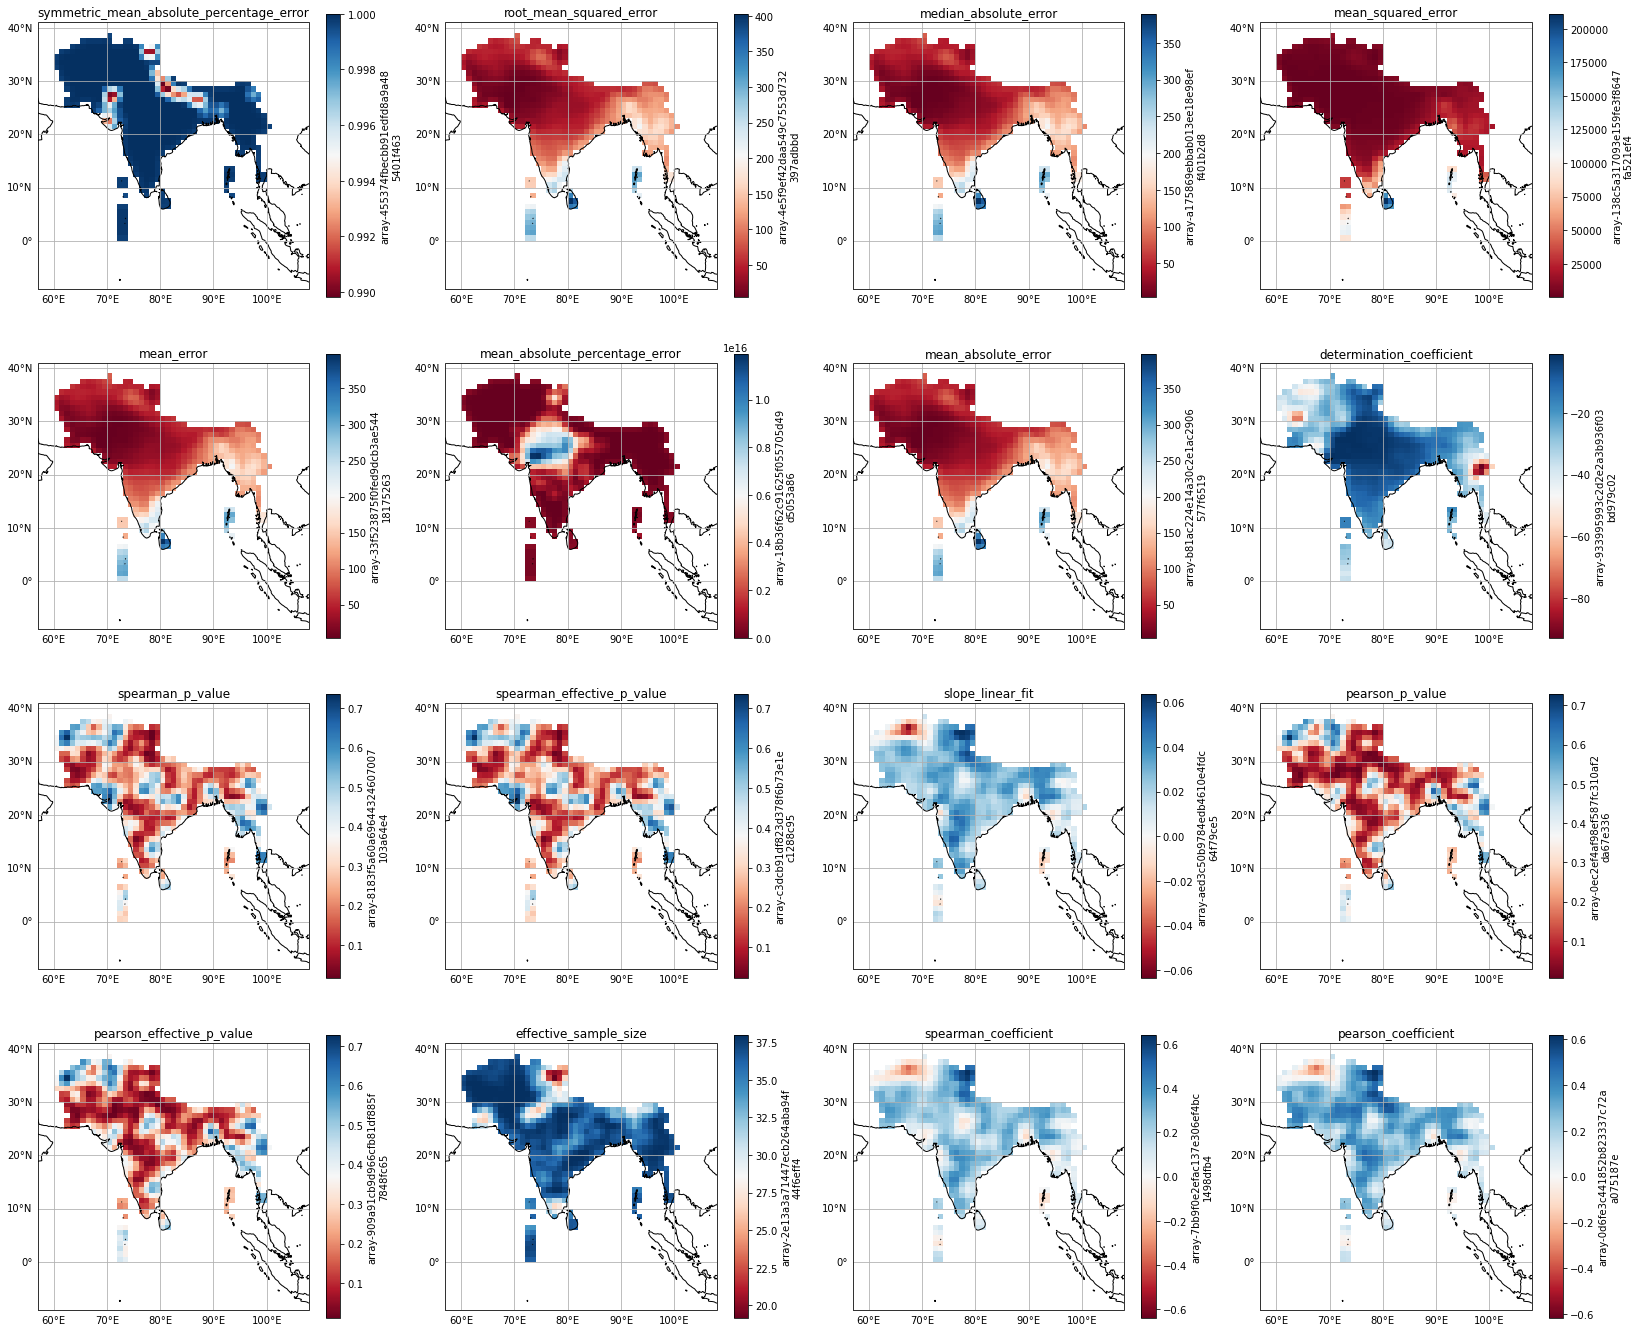

In [16]:
xc.view_skill(skill, blur=(3,3), opfile='test.png')

In [22]:
ioa = xc.IndexOfAgreement()(elm_hcst.hindcasts, Y,  )

ioa.plot()


AssertionError: XCast requires a dataset_sample_dim to be a dimension on X